# Feature engineering 

This notebook considers the results from the previous notebook "0_contact_datasets.ipynb" which purpose was to combine the datasets which were in raw format and the resulting dataframe has additional columns about the battery usage and charging modes that were categorically encoded. 

In this Noetbook, the focus will me on feature engineering and training a base link model. 

## Importing libraries

In [19]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

## Loading data

In [20]:
# Load the combined dataset
dataset_path = "../data/processed/combined_dataframe.csv"
data = pd.read_csv(dataset_path)

In [21]:
data.head()

,Date,Temperature,Charge_Start,Charge_End,Daily_Cycles,Total_Cycles,SOH,Usage_Pattern,Charging_Pattern
0,2021-09-04,15.157374,20,80,0.231811,0.231811,99.994349,0,0
1,2021-09-05,9.269284,20,100,0.389300,0.621111,99.985886,0,0
2,2021-09-06,11.597141,20,80,0.390959,1.012070,99.978053,0,0
3,2021-09-07,6.811304,20,80,0.254491,1.266561,99.973179,0,0
4,2021-09-08,7.221331,20,80,0.367787,1.634349,99.968001,0,0


## Feature Engineering

### Explanation of the new features:
- **Temperature_Optimal**: Binary indicator for optimal temperature range (15-35°C).

- **Temperature_Extreme**: Binary indicator for extreme temperatures.

- **Temp_Deviation_Low and Temp_Deviation_High**: Measure how far the temperature is from the optimal range.

- **Season**: Categorical feature indicating the season based on the month.

- **Usage_Intensity**: Categorizes daily cycles into low, normal, and high usage.

- **Deep_Discharge**: Indicates if the battery experienced deep discharge or full charge.

- **Optimal_Charging**: Indicates if the charging was within the optimal range (20-80%).

- **Cycle_Age**: Normalized total cycles to represent the battery's age.

- **SOH_Change_Rate**: Rate of change in SOH, which can capture degradation trends.

=> These new features relate to the factors influencing SOH degradation.  
=> It captures temperature effects, usage patterns, charging behaviors, which should provide a richer set of features for the linear regression model to work with.

In [35]:
def engineer_features(df):
    # Calculate charge difference
    df['Charge_Difference'] = df['Charge_End'] - df['Charge_Start']
    
    # Temperature-related features
    df['Temperature_Optimal'] = ((df['Temperature'] >= 15) & (df['Temperature'] <= 35)).astype(int)
    df['Temperature_Extreme'] = ((df['Temperature'] < -10) | (df['Temperature'] > 40)).astype(int)
    
    # Temperature deviation from optimal range
    df['Temp_Deviation_Low'] = np.maximum(15 - df['Temperature'], 0)
    df['Temp_Deviation_High'] = np.maximum(df['Temperature'] - 35, 0)
    
    # Seasonal indicator (assuming date is in datetime format)
    # df['Season'] = df['Date'].dt.month % 12 // 3 + 1  # 1: Winter, 2: Spring, 3: Summer, 4: Autumn
    
    # Usage intensity
    df['Usage_Intensity'] = pd.cut(df['Daily_Cycles'], 
                                   bins=[-np.inf, 0.5, 1.0, np.inf], 
                                   labels=[0, 1, 2])  # 0: Low, 1: Normal, 2: High
    
    # Charging behavior features
    df['Deep_Discharge'] = ((df['Charge_Start'] < 10) | (df['Charge_End'] > 90)).astype(int)
    df['Optimal_Charging'] = ((df['Charge_Start'] >= 20) & (df['Charge_End'] <= 80)).astype(int)
    
    # Cycle-related features
    df['Cycle_Age'] = df['Total_Cycles'] / df['Total_Cycles'].max()  # Normalized cycle age
    
    
    # Calculate SOH change rate and fill NaN with 0
    df['SOH_Change_Rate'] = (df['SOH'].diff() / df['SOH'].shift(1)).fillna(0)
    
    return df

In [41]:
# Apply feature engineering
data = engineer_features(data)

In [42]:
# Visulize the new dataframe with the new featrures
data.head(10)

,Date,Temperature,Charge_Start,Charge_End,Daily_Cycles,Total_Cycles,SOH,Usage_Pattern,Charging_Pattern,Charge_Difference,Temperature_Optimal,Temperature_Extreme,Temp_Deviation_Low,Temp_Deviation_High,Usage_Intensity,Deep_Discharge,Optimal_Charging,Cycle_Age,SOH_Change_Rate
0,2021-09-04,15.157374,20,80,0.231811,0.231811,99.994349,0,0,60,1,0,0.000000,0.0,0,0,1,0.000141,0.000000
1,2021-09-05,9.269284,20,100,0.389300,0.621111,99.985886,0,0,80,0,0,5.730716,0.0,0,1,0,0.000378,-0.000085
2,2021-09-06,11.597141,20,80,0.390959,1.012070,99.978053,0,0,60,0,0,3.402859,0.0,0,0,1,0.000616,-0.000078
3,2021-09-07,6.811304,20,80,0.254491,1.266561,99.973179,0,0,60,0,0,8.188696,0.0,0,0,1,0.000771,-0.000049
4,2021-09-08,7.221331,20,80,0.367787,1.634349,99.968001,0,0,60,0,0,7.778669,0.0,0,0,1,0.000995,-0.000052
5,2021-09-09,17.838037,20,100,0.265036,1.899385,99.960855,0,0,80,1,0,0.000000,0.0,0,1,0,0.001156,-0.000071
6,2021-09-10,14.024863,20,80,0.366294,2.265678,99.952237,0,0,60,0,0,0.975137,0.0,0,0,1,0.001379,-0.000086
7,2021-09-11,13.698523,20,80,0.378283,2.643961,99.946555,0,0,60,0,0,1.301477,0.0,0,0,1,0.001609,-0.000057
8,2021-09-12,16.426912,20,80,0.436564,3.080525,99.939615,0,0,60,1,0,0.000000,0.0,0,0,1,0.001875,-0.000069
9,2021-09-13,4.474980,20,80,0.288286,3.368811,99.932098,0,0,60,0,0,10.525020,0.0,0,0,1,0.002051,-0.000075


In [43]:
data.columns

Index(['Date', 'Temperature', 'Charge_Start', 'Charge_End', 'Daily_Cycles',
       'Total_Cycles', 'SOH', 'Usage_Pattern', 'Charging_Pattern',
       'Charge_Difference', 'Temperature_Optimal', 'Temperature_Extreme',
       'Temp_Deviation_Low', 'Temp_Deviation_High', 'Usage_Intensity',
       'Deep_Discharge', 'Optimal_Charging', 'Cycle_Age', 'SOH_Change_Rate'],
      dtype='object')

## Base model training

### Features & target

In [44]:
# Define features and target

features = ['Temperature', 'Charge_Start', 'Charge_End', 'Daily_Cycles',
       'Total_Cycles', 'Usage_Pattern', 'Charging_Pattern',
       'Charge_Difference', 'Temperature_Optimal', 'Temperature_Extreme',
       'Temp_Deviation_Low', 'Temp_Deviation_High', 'Usage_Intensity',
       'Deep_Discharge', 'Optimal_Charging', 'Cycle_Age', 'SOH_Change_Rate']

target = 'SOH'

### Train Test Split

In [45]:
# Split the data into training and testing sets
X = data[features]
y = data[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Encoding 

In [46]:
# Scale the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
X_train_scaled_df = pd.DataFrame(X_train_scaled)
X_train_scaled_df.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.633240,-0.983616,0.867036,-0.242318,-0.085494,-0.004954,1.727741,1.077660,1.237449,-0.335091,-0.780594,-0.218245,-0.004954,1.21318,-1.21318,-0.085494,-0.043136
1,-0.227172,2.120394,-0.811510,0.330801,-0.031814,-0.004954,0.862307,-1.918598,-0.808114,-0.335091,-0.135793,-0.218245,-0.004954,-0.82428,0.82428,-0.031814,-0.026833
2,-0.718944,-0.137068,-0.811510,-0.365160,0.391765,-0.004954,-0.868560,-0.206450,-0.808114,-0.335091,0.647397,-0.218245,-0.004954,-0.82428,0.82428,0.391765,-0.015365
3,1.548983,-0.137068,-0.811510,2.554407,3.223888,1.732245,-0.868560,-0.206450,1.237449,-0.335091,-0.780594,-0.218245,1.732245,-0.82428,0.82428,3.223888,-0.040174
4,0.112334,-0.701433,1.426551,-0.691842,-1.274298,-0.004954,-0.003126,1.077660,-0.808114,-0.335091,-0.676485,-0.218245,-0.004954,1.21318,-1.21318,-1.274298,-0.025596


### Liner regression model 

In [47]:
# Train a Linear Regression model
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression()

### Results with no feature engineering 

In [9]:
# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')

# Print feature coefficients
for feature, coef in zip(features, model.coef_):
    print(f'{feature}: {coef}')

Mean Squared Error: 1.575695439580342
R-squared Score: 0.9486610340650645
Temperature: -971177015072.3562
Charge_Start: -874603509166.7933
Charge_End: 441092689340.6168
Daily_Cycles: 0.20118709174430027
Total_Cycles: -5.626372970512064
Usage_Pattern: 0.8041358136213483
Charging_Pattern: -1.4661836757673106
Charge_Difference: -1153162343425.927
Temperature_Deviation: 971177015072.2642
Temp_Cycles_Interaction: 0.07370776765929439


### Training metrics - model prefromance KPIs 

In [49]:
# Predict and evaluate
y_pred = model.predict(X_test_scaled)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared Score: {r2}')

# Print feature coefficients
for feature, coef in zip(features, model.coef_):
    print(f'{feature}: {coef}')

Mean Squared Error: 1.5205324822692499
R-squared Score: 0.9504583415364999
Temperature: -0.04659006211182391
Charge_Start: -177362427281.99628
Charge_End: 89449984152.24968
Daily_Cycles: 0.14686237556118187
Total_Cycles: 2543045168.0401416
Usage_Pattern: 5427772178.239118
Charging_Pattern: -2.3596356013621778
Charge_Difference: -233851877036.5389
Temperature_Optimal: -0.08511797763010596
Temperature_Extreme: -0.013972699863226287
Temp_Deviation_Low: -0.059755982546277765
Temp_Deviation_High: 0.005524534768518941
Usage_Intensity: -5427772177.390258
Deep_Discharge: -292910571.95655334
Optimal_Charging: -292910576.7607335
Cycle_Age: -2543045173.6305413
SOH_Change_Rate: 0.034086611245201986


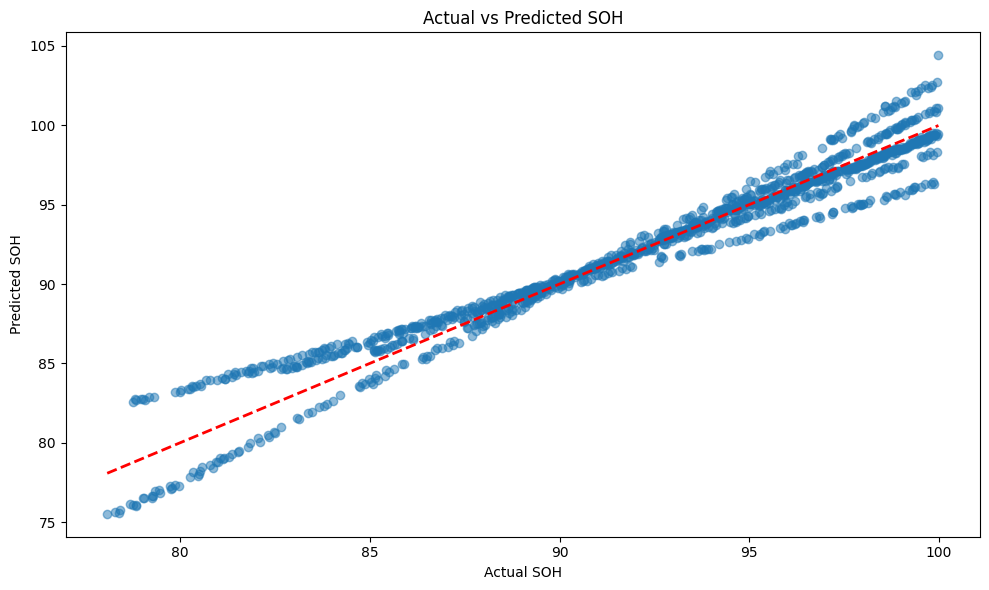

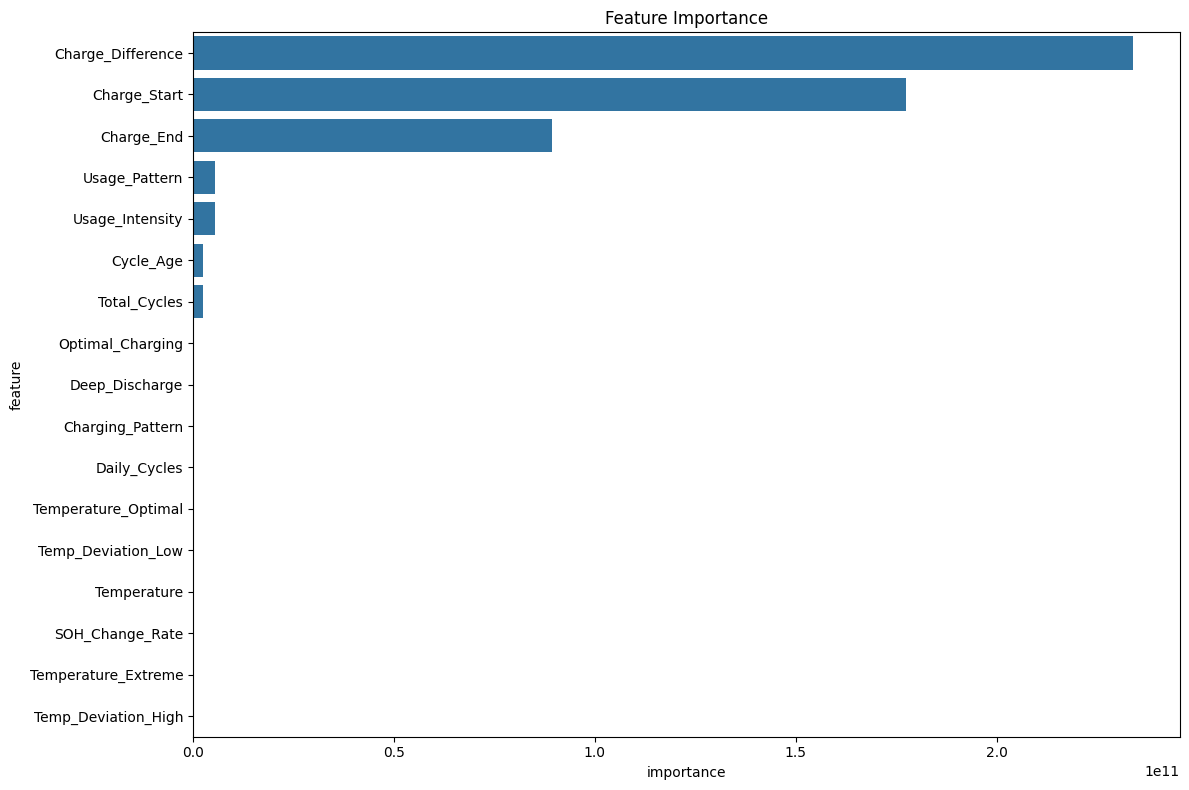

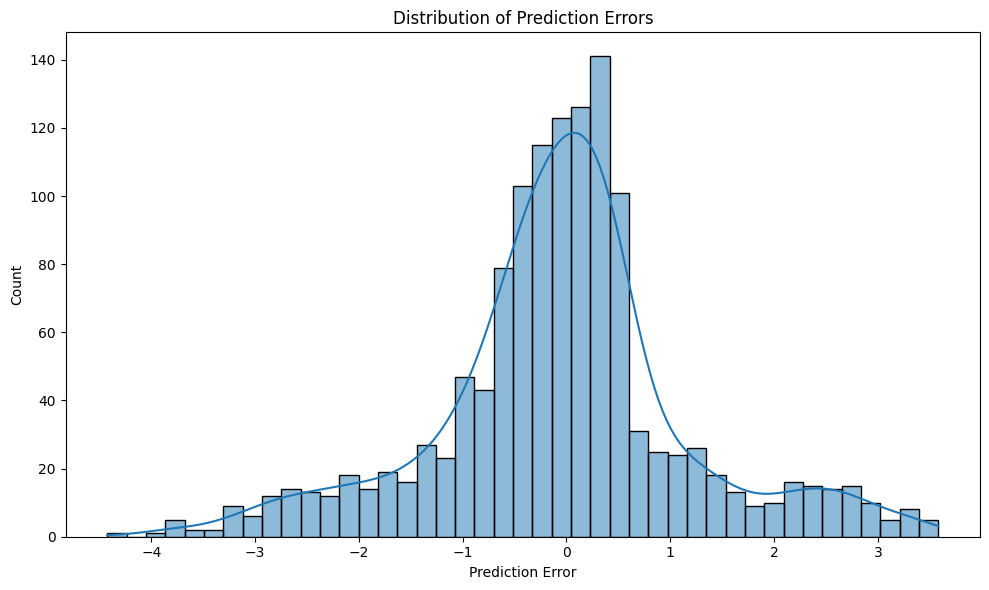

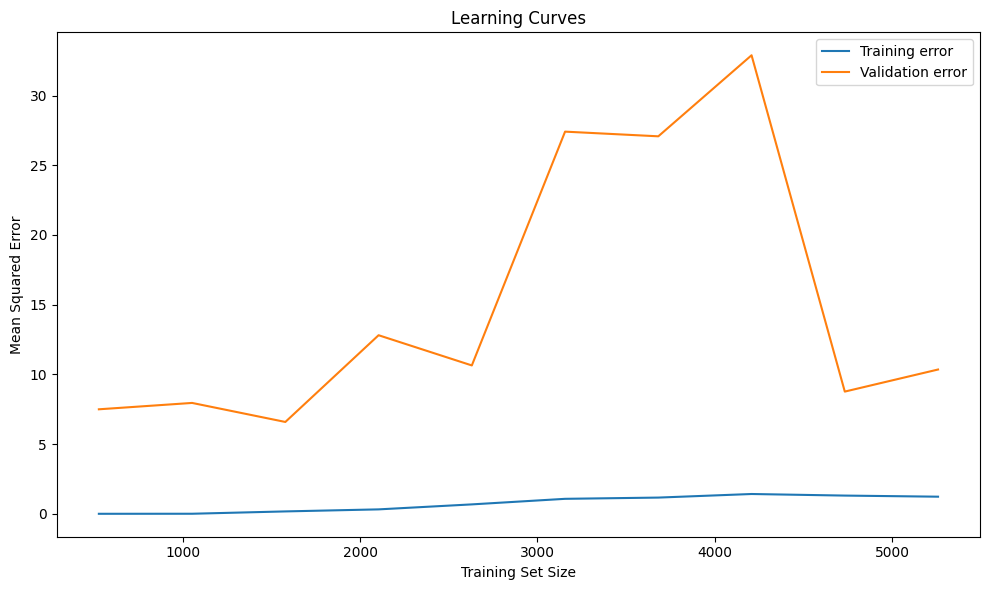

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.linear_model import LinearRegression


# 1. Actual vs Predicted Plot
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual SOH')
plt.ylabel('Predicted SOH')
plt.title('Actual vs Predicted SOH')
plt.tight_layout()
plt.show()

# 3. Feature Importance Plot
feature_importance = pd.DataFrame({'feature': features, 'importance': abs(model.coef_)})
feature_importance = feature_importance.sort_values('importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=feature_importance)
plt.title('Feature Importance')
plt.tight_layout()
plt.show()

# 4. Prediction Error Distribution
plt.figure(figsize=(10, 6))
residuals = y_test - y_pred
sns.histplot(residuals, kde=True)
plt.xlabel('Prediction Error')
plt.title('Distribution of Prediction Errors')
plt.tight_layout()
plt.show()

# 5. Learning Curves
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    LinearRegression(), X, y, cv=5, n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10), scoring='neg_mean_squared_error')

train_scores_mean = -train_scores.mean(axis=1)
test_scores_mean = -test_scores.mean(axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_scores_mean, label='Training error')
plt.plot(train_sizes, test_scores_mean, label='Validation error')
plt.xlabel('Training Set Size')
plt.ylabel('Mean Squared Error')
plt.title('Learning Curves')
plt.legend()
plt.tight_layout()
plt.show()

## Base model review 

The linear regression model seem to underfit based on the last plot of the MSE

## Prediction

In [48]:
# Function to predict SOH for new data
def predict_soh(new_data):
    new_data = engineer_features(new_data)
    new_data_scaled = scaler.transform(new_data[features])
    return model.predict(new_data_scaled)

# Example usage:
# new_battery_data = pd.DataFrame({...})  # Your new data here
# predicted_soh = predict_soh(new_battery_data)
# print(f'Predicted SOH: {predicted_soh[0]}')